In [1]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [5]:
!kaggle competitions download -c dog-breed-identification

 98% 676M/691M [00:03<00:00, 237MB/s]
100% 691M/691M [00:03<00:00, 222MB/s]


In [6]:
!unzip -q dog-breed-identification.zip

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data analyse

In [8]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
print(len(df))
print(df["breed"].nunique())
print(df["breed"].unique())

10222
120
['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier'
 'kuvasz' 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 'malinois' 'komondor' 'airedale' 'leonberg' 

In [10]:
df["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

# Load data

In [11]:
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [12]:
# Path to your image directory
data_directory = 'train'

# Add a new column with the full path to the image
df['path'] = df['id'].apply(lambda x: f'{data_directory}/{x}.jpg')

# Encode labels to integers
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['breed'])

df.head()

,id,breed,path,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,49


In [13]:
# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

In [34]:
# Create a function to load and preprocess images
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (160, 160))  # Adjust the target size according to your model requirements
    return img, label

In [35]:
# Create TensorFlow Datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_df['label'].values))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_df)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_df['path'].values, validation_df['label'].values))
validation_dataset = validation_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


## Visualize some data

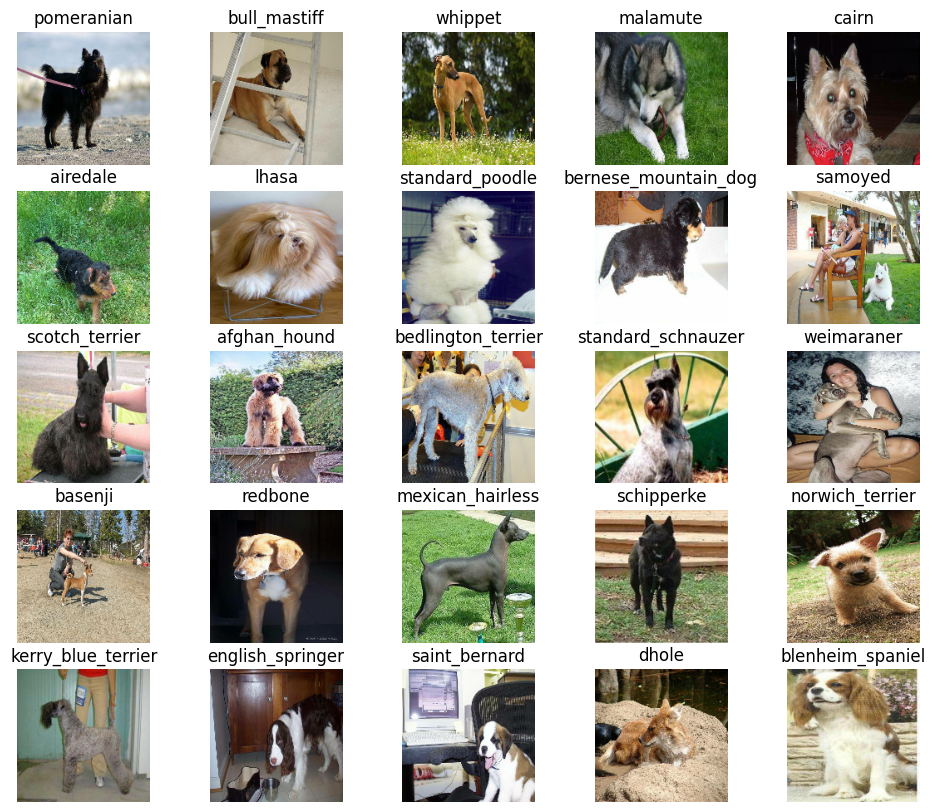

In [36]:
# Function to show a batch of images with labels as titles
def show_batch(dataset, label_encoder, num_samples=25):
    plt.figure(figsize=(12, 10))
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(labels))):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy()/255)
            plt.title(label_encoder.inverse_transform([labels[i].numpy()])[0])
            plt.axis("off")

# Show a batch of images from the training dataset
show_batch(train_dataset, label_encoder)
plt.show()

## Model Architecture

In [37]:
# Data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [38]:
# Create a custom layer for MobileNetV2 preprocessing
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()

    def call(self, inputs):
        return tf.keras.applications.densenet.preprocess_input(inputs)

In [39]:
# Create base model
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3)
)

# Freeze the base model
base_model.trainable = False

# Build the model with data augmentation and MobileNetV2 base
model = tf.keras.Sequential([
    PreprocessLayer(),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

Epoch 1/5
256/256 [==============================] - 53s 106ms/step - loss: 4.4736 - accuracy: 0.0532 - val_loss: 3.1041 - val_accuracy: 0.3095
Epoch 2/5
256/256 [==============================] - 32s 87ms/step - loss: 3.4735 - accuracy: 0.1693 - val_loss: 1.9748 - val_accuracy: 0.5105
Epoch 3/5
256/256 [==============================] - 33s 87ms/step - loss: 2.9980 - accuracy: 0.2432 - val_loss: 1.5909 - val_accuracy: 0.5746
Epoch 4/5
256/256 [==============================] - 60s 91ms/step - loss: 2.7512 - accuracy: 0.2787 - val_loss: 1.4626 - val_accuracy: 0.6034
Epoch 5/5
256/256 [==============================] - 35s 84ms/step - loss: 2.6000 - accuracy: 0.3114 - val_loss: 1.3693 - val_accuracy: 0.6200


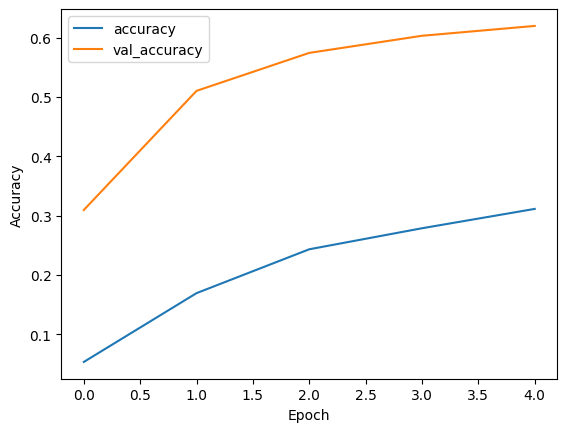

In [40]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## use different layers of network

In [41]:
len(base_model.layers)

427

You can access specific layer of your model by layer number


```
my_model1 = tf.keras.Model(inputs=base_model.input,
        outputs=[base_model.layers[50]])
```



or layer name

```
my_model2 = tf.keras.Model(inputs=base_model.input,
        outputs=base_model.get_layer('name').output)
```


In [43]:
len(base_model.layers)

427

In [47]:
# Get the specific layers you are interested in
mid_level = base_model.layers[350].output
final_output = base_model.output

# Apply Global Average Pooling to each specific layer
gap_mid = tf.keras.layers.GlobalAveragePooling2D()(mid_level)
gap_final = tf.keras.layers.GlobalAveragePooling2D()(final_output)

#concat
out = tf.keras.layers.Concatenate()([gap_mid, gap_final])

# Create a model with the original input and the GAP outputs
base = tf.keras.Model(inputs=base_model.input, outputs=out)

In [48]:
# Build the model with data augmentation and MobileNetV2 base
model = tf.keras.Sequential([
    PreprocessLayer(),
    data_augmentation,
    base,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

Epoch 1/5
256/256 [==============================] - 44s 98ms/step - loss: 4.4772 - accuracy: 0.0552 - val_loss: 3.1536 - val_accuracy: 0.2689
Epoch 2/5
256/256 [==============================] - 31s 81ms/step - loss: 3.4880 - accuracy: 0.1629 - val_loss: 2.0431 - val_accuracy: 0.4856
Epoch 3/5
256/256 [==============================] - 32s 85ms/step - loss: 3.0348 - accuracy: 0.2305 - val_loss: 1.6570 - val_accuracy: 0.5531
Epoch 4/5
256/256 [==============================] - 31s 82ms/step - loss: 2.7686 - accuracy: 0.2737 - val_loss: 1.4739 - val_accuracy: 0.6039
Epoch 5/5
256/256 [==============================] - 37s 89ms/step - loss: 2.6524 - accuracy: 0.3043 - val_loss: 1.3655 - val_accuracy: 0.6112


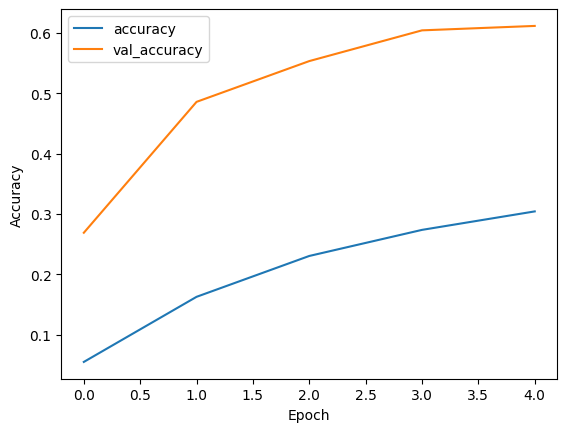

In [49]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()